# Amazon, performance

In [1]:
import collabclass
import matplotlib.pyplot as plt
import numpy as np
import pickle

In [2]:
%%time
with open("../_data/amazon/categories-final.pkl", "rb") as f:
    cats = pickle.load(f)
    
with open("../_data/amazon/graph-final.pkl", "rb") as f:
    data = pickle.load(f)
    graph = data["graph"]
    item2idx = data["item2idx"]
    user2idx = data["user2idx"]
    
m = len(graph.user_idx)
n = len(graph.item_idx)
k = len(set(cats.values()))

cls2idx = {cls: idx for idx, cls in enumerate(sorted(set(cats.values())))}

idx2item = {v: k for k, v in item2idx.items()}
vs = list()
for j in range(n):
    cat = cats[idx2item[j]]
    vs.append(cls2idx[cat])
vs = np.array(vs)

CPU times: user 12.9 s, sys: 2.45 s, total: 15.3 s
Wall time: 15.4 s


In [3]:
print("Number of users: {:,}".format(m))
print("Number of items:  {:,}".format(n))
print("Number of edges: {:,}".format(len(graph.user_edges)))

Number of users: 14,216,570
Number of items:  4,849,549
Number of edges: 43,065,188


In [4]:
np.random.seed(0)
vs_hat = collabclass.symmetric_channel(vs, k, delta=0.1)

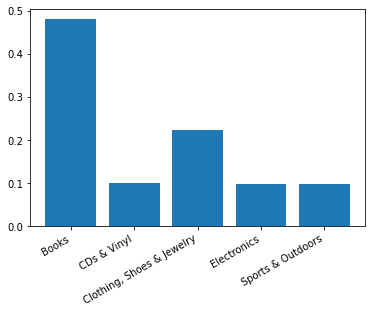

In [5]:
vals, cnts = np.unique(vs, return_counts=True)

fig, ax = plt.subplots()
ax.bar(vals, cnts / cnts.sum());
ax.set_xticks(vals)
ax.set_xticklabels(sorted(set(cats.values())), rotation=30, ha="right");

## CAVI

In [6]:
alpha = np.ones((m, k))
beta = collabclass.init_beta(k, vs_hat, delta=0.20)

In [7]:
%%time
apost, bpost = collabclass.cavi(graph, alpha, beta, 3)
vs_bar = np.argmax(bpost, axis=1)

CPU times: user 1min 9s, sys: 886 ms, total: 1min 10s
Wall time: 1min 10s


In [8]:
collabclass.print_accuracy(vs_bar, vs, vs_hat)

accuracy:   0.9262
error rate: 0.0738
FP rate:    0.0100
FN rate:    0.6478


In [9]:
collabclass.degree_breakdown(vs_bar, vs, graph, qs=(50, 90, 98))

accuracy at 50th percentile (d ≥ 2): 0.9378
accuracy at 90th percentile (d ≥ 15): 0.9606
accuracy at 98th percentile (d ≥ 66): 0.9623


array([[2215799.,   30735.,   27450.,   28795.,   26683.],
       [  18789.,  452206.,    4586.,    5270.,    4437.],
       [  37518.,   21877.,  974535.,   25844.,   24454.],
       [  15816.,    8770.,    9609.,  430024.,    9404.],
       [  19364.,    9828.,   14984.,   13882.,  418890.]])

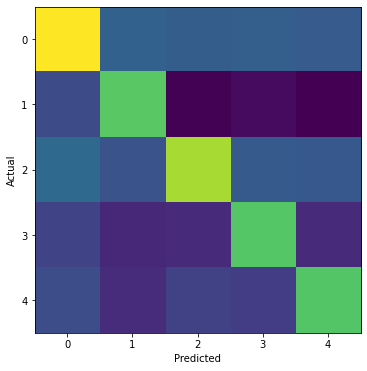

In [10]:
collabclass.confusion_matrix(vs_bar, vs)

What about if we "loosen" the criterion a bit and look at the top-2 classes?

In [11]:
collabclass.degree_breakdown_topk(bpost, vs, graph, k=2)

top-2 accuracy at 0th percentile (d ≥ 1): 0.9755
top-2 accuracy at 50th percentile (d ≥ 2): 0.9819
top-2 accuracy at 90th percentile (d ≥ 15): 0.9898
top-2 accuracy at 95th percentile (d ≥ 29): 0.9899


## wvRN

In [12]:
%%time
vs_bar = collabclass.wvrn(graph, vs_hat)

CPU times: user 7.77 s, sys: 240 ms, total: 8.01 s
Wall time: 8.02 s


In [13]:
collabclass.print_accuracy(vs_bar, vs, vs_hat)

accuracy:   0.7177
error rate: 0.2823
FP rate:    0.2820
FN rate:    0.2850


In [14]:
collabclass.degree_breakdown(vs_bar, vs, graph, qs=(50, 90, 95, 99))

accuracy at 50th percentile (d ≥ 2): 0.7720
accuracy at 90th percentile (d ≥ 15): 0.8382
accuracy at 95th percentile (d ≥ 29): 0.8359
accuracy at 99th percentile (d ≥ 115): 0.8136


array([[2097944.,   69171.,   57299.,   77978.,   27070.],
       [ 100921.,  360756.,    7066.,   13257.,    3288.],
       [ 302255.,   29500.,  586498.,  103456.,   62519.],
       [ 125245.,   16258.,   37493.,  273066.,   21561.],
       [ 134280.,   13928.,   84126.,   82138.,  162476.]])

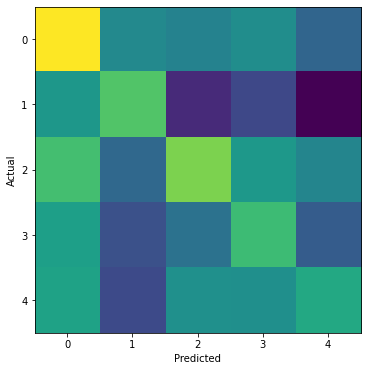

In [15]:
collabclass.confusion_matrix(vs_bar, vs)

## Deep dive into CAVI errors

In [16]:
%%time
# Initialize using the _true_ labels this time.
beta = collabclass.init_beta(k, vs, delta=0.20)
apost, bpost = collabclass.cavi(graph, alpha, beta, 3)
vs_bar = np.argmax(bpost, axis=1)

CPU times: user 1min 9s, sys: 1.46 s, total: 1min 11s
Wall time: 1min 11s


In [17]:
idx2cls = {v: k for k, v in cls2idx.items()}
indices = np.argwhere(vs_bar != vs).ravel()
degrees = graph.item_idx[indices,1]

for d, i in sorted(zip(degrees, indices), reverse=True)[:10]:
    print("---")
    print(f"degree: {d}")
    print(f"actual: {cats[idx2item[i]]}, predicted: {idx2cls[vs_bar[i]]}")
    print(f"URL: https://www.amazon.com/dp/{idx2item[i]}")

---
degree: 4735
actual: Electronics, predicted: Books
URL: https://www.amazon.com/dp/B005DOK8NW
---
degree: 3066
actual: Sports & Outdoors, predicted: Electronics
URL: https://www.amazon.com/dp/B000LIFB7S
---
degree: 1620
actual: Electronics, predicted: Books
URL: https://www.amazon.com/dp/B004JXVOD6
---
degree: 1562
actual: Electronics, predicted: Books
URL: https://www.amazon.com/dp/B006BGZJJ4
---
degree: 1306
actual: Electronics, predicted: Books
URL: https://www.amazon.com/dp/B007R5YGO2
---
degree: 1229
actual: Electronics, predicted: Books
URL: https://www.amazon.com/dp/B006ZBWV0K
---
degree: 1166
actual: Electronics, predicted: Books
URL: https://www.amazon.com/dp/B005QCDY50
---
degree: 1156
actual: Electronics, predicted: Books
URL: https://www.amazon.com/dp/B004JWA70I
---
degree: 1135
actual: Electronics, predicted: Books
URL: https://www.amazon.com/dp/B0079UAT0A
---
degree: 981
actual: Electronics, predicted: Books
URL: https://www.amazon.com/dp/B009NHWVIA
